In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import mpl_toolkits as mplot3d

pd.set_option("display.max_columns", None)
from tqdm import tqdm
tqdm.pandas()

In [2]:
import_folder_path = rf"..\..\[1] Datasets\India\Dynata"

# DATA WRANGLING

In [3]:
df00 = pd.read_csv(rf"{import_folder_path}/Indian Risk Literacy DYNATA_280525.csv")[26:]

# drop na in responses
df01 = df00.dropna(subset = df00.columns[19:77])
print("Post dropping NA:", len(df01["ResponseId"]))

# removing students
df01 = df01.loc[ ~(df01["Q4a"] == "Student")].copy()
print("Post removing students:", len(df01["ResponseId"]))

# removing straight liners
matrix = ["Q8_1", "Q8_2", "Q8_3", "Q8_4", "Q8_5", "Q8_6", "Q8_7", "Q8_8"]
dict = {"1 (strongly disagree)":1 , "2":2, "3":3, "4":4, "5":5, "6 (strongly agree)":6}
for ques in matrix:
    df01[ques] = df01[ques].astype(str).replace(dict)
df01["Q8_std"] = df01[matrix].std(axis = 1)
df01 = df01.loc[ df01["Q8_std"] != 0].copy()
print("Post removing straightliners:", len(df01["ResponseId"]))

# attention check
df01 = df01.loc[ df01["Attention Check"] == "Vase"].copy()
print("Post attention chaeck failures:", len(df01["ResponseId"]))

# <0.5 median time of completion filtered
df01["Duration (in seconds)"] = df01["Duration (in seconds)"].astype("Int64")
median = df01["Duration (in seconds)"].astype("Int64").median()
df01 = df01.loc[ df01["Duration (in seconds)"] >= median*0.5].copy()
print("Post removing <0.5 median time responses:", len(df01["ResponseId"]))

df0 = df01.iloc[:, 19:77].copy().reset_index(drop = True)
df0.insert(0, "ResponseId", range(0, len(df0)))

Post dropping NA: 963
Post removing students: 961
Post removing straightliners: 846
Post attention chaeck failures: 846
Post removing <0.5 median time responses: 699


In [4]:
df0["age"] = df0["Q2"].astype(float).copy()

# Age groups/rec = [2,3,4]
# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o (75 y/o, i.e, within the scope of the data we have, it can mean 60 and above also)

df0["age_rec"] = np.where( (df0["age"] >= 18) & (df0["age"] <= 35), 2,
                          np.where( (df0["age"] >= 36) & (df0["age"] <= 55), 3,
                                   np.where( (df0["age"] >= 56), 4, 0
                                           )
                                  )
                         )

# Secondary upto 10 – ISCED 3
# Senior Secondary upto 12 - ISCED 3 
# Diploma and voca – ISCED 2
# UG – ISCED 2
# PG – ISCED 1
# PhD and higher – ISCED 1

df0["isced"] = np.where(df0["Q3"] == "Post-Graduate Program", 1,
                        np.where(df0["Q3"] == "Undergraduate Program", 2,
                                 np.where(df0["Q3"] == "Ph.D. and higher", 1,
                                          np.where(df0["Q3"] == "Diploma and Vocational Training", 2,
                                                   np.where(df0["Q3"] == "Secondary School (11th to 12th Std.)", 3,
                                                            np.where( df0["Q3"] == "Primary School (up to 10th Std.)", 3,
                                                                     np.where( df0["Q3"] == "M.Phil.", 1, 0
                                                                             )
                                                                    )
                                                           )
                                                  )
                                         )
                                )
                       )

df0["income"] = np.where(df0["Q15a"] == "< INR 500,000", 1,
                         np.where(df0["Q15a"] == "INR 500,001 – INR 15,00,000", 2,
                                  np.where(df0["Q15a"] == "INR 1500,001 – INR 30,00,000", 3,
                                           np.where(df0["Q15a"] == "INR 30,00,001 – INR 50,00,000", 4,
                                                    np.where(df0["Q15a"] == "INR 50,00,001 – INR 75,00,000", 5,
                                                             np.where( df0["Q15a"] == "> INR 75,00,000", 6,0
                                                                     )
                                                            )
                                                   )
                                           )
                                  )
                         )

df0["nonwinsorised_wealth"] = df0["Q14b"].astype(float).copy()

In [5]:
def remove_indexname(series): # removes index name
    series.index.name = None
    series.name = None
    return series.to_string()

print("Total Observations:", df0["Q1"].count())

print(f'\nGender:\n{remove_indexname(df0["Q1"].value_counts())}')
print(f'\nOccupation:\n{remove_indexname(df0["Q4a"].value_counts())}')
print(f'\nEducation:\n{remove_indexname(df0["Q3"].value_counts())}')
print(f'\nISCED:\n{remove_indexname(df0["isced"].value_counts())}')
print(f'\nIncome:\n{remove_indexname(df0["Q15a"].value_counts().iloc[[1, 0, 2, 3, 4, 5]])}')

Total Observations: 699

Gender:
Male      361
Female    338

Occupation:
Salaried                       490
Entrepreneur/Business Owner    129
Currently not employed          68
Retired                         12

Education:
Post-Graduate Program                   225
Undergraduate Program                   206
Secondary School (11th to 12th Std.)    177
Diploma and Vocational Training          35
Primary School (up to 10th Std.)         29
Ph.D. and higher                         16
M.Phil.                                  11

ISCED:
1    252
2    241
3    206

Income:
< INR 500,000                    194
INR 500,001 – INR 15,00,000      221
INR 1500,001 – INR 30,00,000     114
INR 30,00,001 – INR 50,00,000     76
INR 50,00,001 – INR 75,00,000     52
> INR 75,00,000                   42


## Winsorizing Wealth

In [6]:
## Winsorizing Wealth

from scipy.stats.mstats import winsorize

df0["winsorised_wealth"] = winsorize(np.array(df0["nonwinsorised_wealth"]), limits = [0.1, 0.1], inclusive = [False, False])
df0[["nonwinsorised_wealth", "winsorised_wealth"]].describe()

,nonwinsorised_wealth,winsorised_wealth
count,6.990000e+02,6.990000e+02
mean,1.628566e+08,3.129498e+06
std,3.794346e+09,4.770219e+06
min,0.000000e+00,5.000000e+03
25%,1.000000e+05,1.000000e+05
50%,6.000000e+05,6.000000e+05
75%,4.000000e+06,4.000000e+06
max,1.000000e+11,1.500000e+07


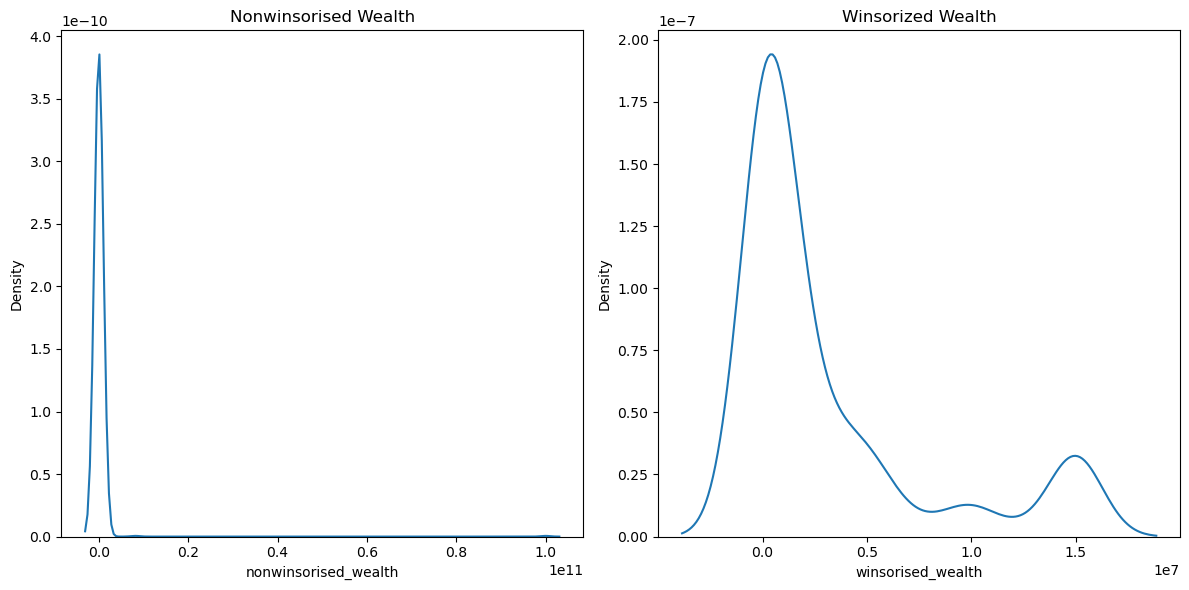

In [7]:
# WEALTH - winsorized, and non winsorized

fig, axes = plt.subplots(1, 2, figsize = (12, 6))

sns.kdeplot(data = df0["nonwinsorised_wealth"].replace([np.inf, -np.inf], np.nan), ax = axes[0])
axes[0].set_title('Nonwinsorised Wealth')

sns.kdeplot(data = df0["winsorised_wealth"].replace([np.inf, -np.inf], np.nan), ax = axes[1])
axes[1].set_title('Winsorized Wealth')

plt.tight_layout()
plt.show()

In [8]:
# Using winsorised wealth as wealth
df0["wealth"] = df0["winsorised_wealth"].copy()

## Questions

In [9]:
matchCol = ["q8_2_1", "q8_2_2", "q8_2_3", "q8_2_4", "q8_2_5", "q8_3", "q8_4", "q8_5berlin_1", 
            "q8_5london_1", "q8_5paris_1", "q8_6", "q8_7", "q9_1_1", "q9_2_1", "q9_3",
            "q10_1_1", "q10_2_1", "q10_3_1", "q10_4"]
df0[ matchCol ] = 0

In [10]:
df0.columns

Index(['ResponseId', 'Q1', 'Q2', 'Q3', 'Q4a', 'Q4.5_4', 'Q4.5_5', 'Q4.5_6',
       'Q5_1', 'Q6 - changed', 'Q8_1', 'Q8_2', 'Q8_3', 'Q8_4', 'Q8_5', 'Q8_6',
       'Q8_7', 'Q8_8', 'Q9b_1', 'Q9b_4', 'Q9b_10', 'Q9b_5', 'Q9b_11', 'Q9b_12',
       'Q9b_6', 'Q9b_7', 'Q9b_8', 'Q9b_13', 'Q9b_14', 'Q9b_9', 'Q14b',
       'Q11a_1', 'Q11a_2', 'Q11a_3', 'Q11b_1', 'Q11b_2', 'Q11b_3', 'Q11b_4',
       'Q11b_5', 'Q11c', 'Q11d', 'Q11h', 'Attention Check', 'Q11i', 'Q13a',
       'Q13b', 'Q13c', 'Q13d', 'Q12a', 'Q12b', 'Q12c', 'Q14a', 'Q14b.1',
       'Q14c', 'Q54', 'Q57', 'Q58', 'Q15a', 'psid', 'age', 'age_rec', 'isced',
       'income', 'nonwinsorised_wealth', 'winsorised_wealth', 'wealth',
       'q8_2_1', 'q8_2_2', 'q8_2_3', 'q8_2_4', 'q8_2_5', 'q8_3', 'q8_4',
       'q8_5berlin_1', 'q8_5london_1', 'q8_5paris_1', 'q8_6', 'q8_7', 'q9_1_1',
       'q9_2_1', 'q9_3', 'q10_1_1', 'q10_2_1', 'q10_3_1', 'q10_4'],
      dtype='object')

In [11]:
df0["q8_2_1"] = np.where(df0["Q11b_1"] == "No", 1, 2)
df0["q8_2_2"] = np.where(df0["Q11b_2"] == "No", 1, 2)
df0["q8_2_3"] = np.where(df0["Q11b_3"] == "No", 1, 2)
df0["q8_2_4"] = np.where(df0["Q11b_4"] == "No", 1, 2)
df0["q8_2_5"] = np.where(df0["Q11b_5"] == "No", 1, 2)

df0["q8_3"] = np.where(df0["Q11c"] == "The lower the quality of the study, the more likely that future studies will change the risk estimate.", 1,
                          np.where(df0["Q11c"] == "The higher the quality of the study, the more likely that future studies will change the risk estimate.", 2,
                                  np.where(df0["Q11c"] == "Irrespective of the quality of the study, future studies will not change the risk estimate.", 3,
                                          np.where(df0["Q11c"] == "Irrespective of the quality of the study, future studies will change the risk estimate substantially anyway.", 4,0
                                                  )
                                          )
                                  )
                         )


df0["q8_4"] = np.where(df0["Q11d"] == "The growth rate will be 0.4% on average each year", 1,
                          np.where(df0["Q11d"] == "The growth rate over five years will be exactly 2%", 2,
                                  np.where(df0["Q11d"] == "The growth rate over five years will be between 1% and 3%", 3,
                                          np.where(df0["Q11d"] == "It is not possible to predict the growth rate with certainty", 4,0
                                                  )
                                          )
                                  )
                         )

In [12]:
df0["q8_5berlin_1"] = np.where(df0["Q11a_1"].astype(int) == 1, 1, 2)
df0["q8_5london_1"] = np.where(df0["Q11a_1"].astype(int) == 1, 1, 2)
df0["q8_5paris_1"] = np.where(df0["Q11a_1"].astype(int) == 1, 1, 2)

df0["q8_6"] = np.where(df0["Q11i"] == "The medication increases recovery by 100%", 1,
                          np.where(df0["Q11i"] == "The medication increases recovery by 50%", 2,
                                   np.where(df0["Q11i"] == "The medication increases recovery by 2%", 3,
                                            np.where(df0["Q11i"] == "None of the above is implied", 4, 0
                                                    )
                                           )
                                  )
                         )

df0["q8_7"] = np.where(df0["Q11h"] == "5 in 100 people prior to the intervention to 6 out of 100 people after the intervention", 1,
                          np.where(df0["Q11h"] == "100 in 10,000 people prior to the intervention to 120 out of 10,000 people after the intervention", 2,
                                   np.where(df0["Q11h"] == "70 in 100 people prior to the intervention to 90 out of 100 people after the intervention", 3,
                                            np.where(df0["Q11h"] == "It is not possible to determine which of the answers is correct given the information provided", 4, 0
                                                    )
                                           )
                                  )
                         )


df0["q9_1_1"] = df0["Q14a"].astype(float).copy()
df0["q9_2_1"] = df0["Q14b.1"].astype(float).copy()

df0["q9_3"] = np.where(df0["Q14c"] == "Crosicol", 1,
                          np.where(df0["Q14c"] == "Hertinol", 2,
                                   np.where(df0["Q14c"] == "They are equal", 3,
                                            np.where(df0["Q14c"] == "Can’t say", 4, 0
                                                    )
                                           )
                                  )
                         )

In [13]:
df0["q10_1_1"] = df0["Q13a"].astype(float).copy()
df0["q10_2_1"] = df0["Q13b"].astype(float).copy()
df0["q10_3_1"] = df0["Q13c"].astype(float).copy()

df0["q10_4"] = np.where(df0["Q13d"] == "9 out of 59", 1,
                          np.where(df0["Q13d"] == "9 out of 10", 2,
                                   np.where(df0["Q13d"] == "59 out of 1000", 3,
                                            np.where(df0["Q13d"] == "59 out of 100", 4, 0
                                                    )
                                           )
                                  )
                         )

## Scoring

In [14]:
scoreColumns = ["certainty1", "certainty2", "certainty3", "certainty4", "certainty5",
                "uncertainty1", "uncertainty2",
                "numeracy1", "numeracy2", "numeracy3", "numeracy4", "numeracy5",
                "graph1", "graph2", "graph3",
                "riskcomprehension1", "riskcomprehension2", "riskcomprehension3", "riskcomprehension4", "riskcomprehension5",
                "bayesian1"
               ]
df0[scoreColumns] = 0

In [15]:
# Assigning scores

def scoring1(surveyFacet):
    surveyFacet.loc[ surveyFacet["q8_2_1"] == 2, "certainty1"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_2"] == 2, "certainty2"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_3"] == 2, "certainty3"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_4"] == 2, "certainty4"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_5"] == 2, "certainty5"] = 1

    surveyFacet.loc[ surveyFacet["q8_3"] == 1, "uncertainty1"] = 1
    surveyFacet.loc[ surveyFacet["q8_4"] == 4, "uncertainty2"] = 1

    surveyFacet.loc[ surveyFacet["q8_5berlin_1"] == 2, "riskcomprehension1"] = 1
    surveyFacet.loc[ surveyFacet["q8_5london_1"] == 1, "riskcomprehension2"] = 1
    surveyFacet.loc[ surveyFacet["q8_5paris_1"] == 1, "riskcomprehension3"] = 1
    
    surveyFacet.loc[ surveyFacet["q8_6"] == 1, "riskcomprehension4"] = 1
    surveyFacet.loc[ surveyFacet["q8_7"] == 4, "riskcomprehension5"] = 1

    surveyFacet.loc[ surveyFacet["q9_1_1"] == 25, "graph1"] = 1
    surveyFacet.loc[ surveyFacet["q9_2_1"] == 20, "graph2"] = 1
    surveyFacet.loc[ surveyFacet["q9_3"] == 3, "graph3"] = 1

    surveyFacet.loc[ surveyFacet["q10_1_1"] == 500, "numeracy1"] = 1
    surveyFacet.loc[ surveyFacet["q10_2_1"] == 10, "numeracy2"] = 1
    surveyFacet.loc[ (surveyFacet["q10_3_1"] == 0.1) | (surveyFacet["q10_3_1"] == ".1") | (surveyFacet["q10_3_1"] == ",1") , "numeracy3"] = 1
    surveyFacet.loc[ surveyFacet["q10_4"] == 1, "bayesian1"] = 1

    # Assigning total scores
    # surveyFacet["Certainty score_5"] = surveyFacet["certainty1"] + surveyFacet["certainty2"] + surveyFacet["certainty3"] + surveyFacet["certainty4"] + surveyFacet["certainty5"]
    #surveyFacet["Uncertainty score_5"] = surveyFacet["uncertainty1"] + surveyFacet["uncertainty2"]

    #surveyFacet["Number Comprehension score_5"] = surveyFacet["numeracy1"] + surveyFacet["numeracy2"] + surveyFacet["numeracy3"] + surveyFacet["numeracy4"] + surveyFacet["numeracy5"]
    #surveyFacet["Graph Comprehension score_5"] = surveyFacet["graph1"] + surveyFacet["graph2"] + surveyFacet["graph3"]

    #surveyFacet["Calculation score_4"] = surveyFacet["riskcalculation1"] + surveyFacet["riskcalculation2"] + surveyFacet["riskcalculation3"] + surveyFacet["riskcalculation4"]

    #surveyFacet["Total Score_19"] = surveyFacet["Certainty score_5"] + surveyFacet["Uncertainty score_5"] + surveyFacet["Number Comprehension score_5"] + surveyFacet["Graph Comprehension score_5"] + surveyFacet["Calculation score_4"]

    return surveyFacet

In [16]:
df10 = df0.groupby(["ResponseId"]).progress_apply(scoring1)
df10 = df10.reset_index(drop = True).dropna().copy()

100%|███████████████████████████████████████████████████████████████████████████████| 699/699 [00:02<00:00, 276.26it/s]


In [17]:
def scoring2(survey):
    
    survey["Certainty_5"] = survey["certainty1"] + survey["certainty2"] + survey["certainty3"] + survey["certainty4"] + survey["certainty5"]
    
    survey["Uncertainty_2"] = survey["uncertainty1"] + survey["uncertainty2"]
    
    survey["RiskComprehension_5"] = survey["riskcomprehension1"] + survey["riskcomprehension2"] + survey["riskcomprehension3"] + survey["riskcomprehension4"] + survey["riskcomprehension5"]
    
    survey["GraphLiteracy_3"] = survey["graph1"] + survey["graph2"] + survey["graph3"]
    
    survey["Numeracy_3"] = survey["numeracy1"] + survey["numeracy2"] + survey["numeracy3"]
    
    survey["Bayesianreasoning_1"] = survey["bayesian1"]
    
    survey["TotalScore_19"] = survey["Certainty_5"] + survey["Uncertainty_2"] + survey["RiskComprehension_5"] + survey["GraphLiteracy_3"] + survey["Numeracy_3"] + survey["Bayesianreasoning_1"]
    
    survey["Certainty_%"] = survey["Certainty_5"] / 5 * 100
    survey["Uncertainty_%"] = survey["Uncertainty_2"] / 2 * 100
    survey["RiskComprehension_%"] = survey["RiskComprehension_5"] / 5 * 100
    survey["GraphLiteracy_%"] = survey["GraphLiteracy_3"] / 3 * 100
    survey["Numeracy_%"] = survey["Numeracy_3"] / 3 * 100
    survey["Bayesianreasoning_%"] = survey["Bayesianreasoning_1"] / 1 * 100
    
    survey["TotalScore_%"] = survey["TotalScore_19"] / 19 * 100
    
    
    colReq = ["ResponseId", "age", "age_rec", "isced", "income", "wealth", "Certainty_5", "Uncertainty_2", "RiskComprehension_5", "GraphLiteracy_3",
              "Numeracy_3", "Bayesianreasoning_1", "Certainty_%", "Uncertainty_%", "RiskComprehension_%", "GraphLiteracy_%", "Numeracy_%", "Bayesianreasoning_%",
              "TotalScore_19", "TotalScore_%",]
    
    survey1 = survey[colReq].copy()
    return survey1

In [18]:
df11 = scoring2(df10)

In [1]:
euro = df02.copy()

NameError: name 'df02' is not defined

In [ ]:
# will be used later
wealth_quartile = pd.qcut(euro.loc[~ (euro["wealth"]==-1)]["wealth"],q = 4, labels = False, duplicates = "raise" )

---

---

In [ ]:
#Global Vras:
facet_cols = ["Certainty_5", "Uncertainty_2", "RiskComprehension_5", "GraphLiteracy_3",
              "Numeracy_3", "Bayesianreasoning_1"]

facet_percent_cols = ["Certainty_%", "Uncertainty_%", "RiskComprehension_%", "GraphLiteracy_%",
                      "Numeracy_%", "Bayesianreasoning_%",]

# Study 2 - Europe

## Table 1.1 - Per country: Mean Total Score + SD

In [ ]:
fig, axes = plt.subplots(1, 1, figsize = [12, 6])

mean_scores = euro.groupby("country_text")["TotalScore_19"].mean().sort_index()
std_scores = euro.groupby("country_text")["TotalScore_19"].std().reindex(mean_scores.index)
sem_scores = euro.groupby("country_text")["TotalScore_19"].sem().reindex(mean_scores.index)

axes.bar(mean_scores.index, mean_scores.values, color="skyblue", edgecolor='black')
axes.errorbar(mean_scores.index, mean_scores.values, yerr = [np.zeros_like(sem_scores), sem_scores],
                     fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

axes.set_yticks(np.arange(0, 21))
axes.tick_params(axis = "x", rotation = 45)

for i, (mean, std, sem) in enumerate(zip(mean_scores.values, std_scores.values, sem_scores.values)):
    axes.text(i, mean + 0.5, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
    axes.text(i, 2, f"Mean = {mean:.1f}", ha = "center", va = "center",
              color='white', fontsize=10, fontweight='bold')
    axes.text(i, 1, f"SD = {std:.1f}", ha = "center", va = "center",
              color='black', fontsize=8, fontweight='bold')
    

axes.set_title("Mean Total score by country\nwith 1 std. dev. (1 decimal)", pad = 20)
axes.set_ylabel("Mean Total score")

---

## Table 1.2 - Per country: Mean Facet Scores + SD (Ver. 1)

In [ ]:
fig, axes = plt.subplots(3, 2, figsize = [12, 12])
axes = axes.flatten()

for i, facet in enumerate(facet_cols):
    mean_scores = euro.groupby("country_text")[facet].mean().sort_index()
    std_scores = euro.groupby("country_text")[facet].std().reindex(mean_scores.index)
    sem_scores = euro.groupby("country_text")[facet].sem().reindex(mean_scores.index)
    
    axes[i].bar(mean_scores.index, mean_scores.values, color="skyblue", edgecolor='black')
    axes[i].errorbar(mean_scores.index, mean_scores.values, yerr = [np.zeros_like(sem_scores), sem_scores],
                     fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

    y_max = int(facet.split("_")[1])
    axes[i].set_yticks(np.arange(0, y_max + 1))
    axes[i].tick_params(axis = "x", rotation = 45)
    
    for j, (mean, std, sem) in enumerate(zip(mean_scores.values, std_scores.values, sem_scores.values)):
        axes[i].text(j, mean + 0.025 * y_max, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
        axes[i].text(j, 0.1 * y_max, f"{mean:.1f}", ha = "center", va = "bottom",
                     color='white', fontsize=10, fontweight='bold')
        axes[i].text(j, 0.025 * y_max, f"{std:.1f}", ha = "center", va = "bottom",
                     color='black', fontsize=8, fontweight='bold')

        
    
    axes[i].set_title(f"Mean {facet} by country\nwith ±1 std. dev. (1 decimal)", pad = 20)
    axes[i].set_ylabel(f"Mean {facet}  score")


plt.tight_layout()
plt.show()